 # Target encoding

Esta técnica de codificación de targets (Target Encoding) se utiliza para agrupar información de variables categóricas por cada uno de sus valores en función de la target definida. Conceptualmente es lo mismo que el one-hot encoding, solo que utiliza la target para crear el encode.

### Mean encoding

##### Ejemplo: Automobile 1985 dataset

In [2]:
### Dataset loading

import pandas as pd

automobile_df = pd.read_csv('datasets/automobile_1985_dataset.csv')

Una forma sencilla es agrupando por marca, y reemplazar la marca por la media de `price` por marca. Este tipo de codificación se llama **mean encoding**

In [3]:
automobile_df["make_encoded"] = automobile_df.groupby("make")["price"].transform("mean")

automobile_df[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


### Smoothing

La codificación de estas formas presentan algunos problemas. El primero es el hecho de lidiar con categorías desconocidas, por lo cual son sensibles a producir overfitting. Estos valores desconocidos se deben introducir de alguna manera (con Pandas es bastante sencillo). El segundo problema son las categorías poco usuales. Cuando una categoría de una feature ocurre pocas veces en el dataset, cualquier estadística calculada en este grupo no será muy representativa. Por ejemplo, en el dataset de autos, la marca `mercury` solo aparece una vez, por lo que calcular la media no tendría información adicional.

Una solución a estos problemas es agregar un suavizado, el cual pondera la cantidad de aparición de cada categoría sobre la cantidad de apariciones totales en la feature.

En pseudocódigo sería:

$$
encoding = weight \cdot in\_ category + (1-weight) \cdot overall
$$

donde $weight$ es un valor entre 0 y 1, el cual proviene de la frecuencia de aparición de la clase. Una forma sencilla de fijar un valor de $weight$ es con el método **m-estimate**.

$$
weight = \frac{n}{n+m}
$$

donde $n$ es el número total de veces que la categoría aparece en la data, y $m$ es el parámetro de suavizado.

<img src='https://i.imgur.com/1uVtQEz.png' width="500" align="center">




### Use cases of Target Encoding

- **High-cardinality features**: Una feature con muchas categorías puede traer problemas, ya que si se la codifica con one-hot encoding va a generar muchisimas columnas. Target Encoding relaciona las categorías con la característica mas importante del dataset, el target.

- **Domain-motivated features**: A partir de la experiencia previa, se puede sospechar que una feature debería ser importante aunque haya obtenido una mala puntuación con MI. Un target encoding puede ayudar a revelar la verdadera información de un feature.

##### Ejemplo: MovieLens1M dataset

In [6]:
### Dataset loading

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("datasets/movielens1m_dataset.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint

Analizando la feature `Zipcode` vemos que tiene muchisimas categorías dentro, lo cual la hace una buena cantidada para aplicarle Target Encoding. En principio, se debe crear una división del dataset para entrenar el Target Encoder.

In [7]:
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


In [9]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

El paquete `category_encoders` de *Scikit-learn* tiene una función que implementa el *m-estimate* encoder

In [10]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Ahora comparando nuestra feature codificada con la target podemos ver cuanta información nos otorga.

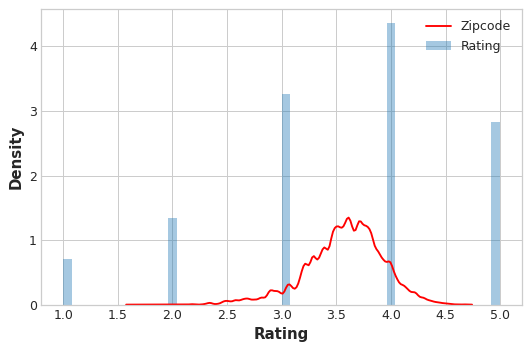

In [11]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

La distribución de la feature `Zipcode` codificada sigue en gran parte la distribución de la target `Rating`, lo que significa que los ratings dependiendo el código postal difieren entre sí lo suficiente para que nuestro encoder pueda captar información útil.